In [1]:
import ee # Google Earth Engine
import datetime
#import ipyleaflet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
# from shapely.geometry import MultiPolygon, Polygon
from shapely.geometry import box
import warnings
from functools import reduce
from math import sin, cos, sqrt, atan2, radians
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.utils import plot_model
# Reference: https://scikit-learn.org/stable/modules/clustering.html#clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, metrics
import seaborn as sns
from scipy.stats.stats import pearsonr
import hdbscan
from scipy.stats import ks_2samp, mannwhitneyu, kruskal, ttest_ind
from itertools import combinations 
%matplotlib inline

Using TensorFlow backend.


In [2]:
ee.Initialize()

Define the function to plot satellite images or pull satellite image data

In [3]:
def satellite_imagery(source, center_lat, center_lon, edge_len,
                      start_date, end_date, 
                      plot_option, time_series, resolution=30):
    # Sentinel-2 Level 1-C: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2
    # Sentinel-2 Level 2-A: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR
    # Landsat Tier structure: https://developers.google.com/earth-engine/landsat#landsat-collection-structure
    if source == "Sentinel2_1C":
        source_loc = 'COPERNICUS/S2'
    elif source == "Sentinel2_2A":
        source_loc = 'COPERNICUS/S2_SR'
    elif source == "Landsat7":
        source_loc = 'LANDSAT/LE07/C01/T1'
    elif source == "Landsat8":
        source_loc = 'LANDSAT/LC08/C01/T1_SR'
#     elif source == "Modis":
#         source_loc = 'MODIS/006/MOD13A2'
    else:
        raise Exception('Invalid source of satellite imagery')
    
    # Specify area of interest (one for ee.Geometry, one for shapely)
#     area_of_interest_ee = ee.Geometry.Polygon([[center_lon-edge_len/2, center_lat-edge_len/2], 
#                            [center_lon-edge_len/2, center_lat+edge_len/2], 
#                            [center_lon+edge_len/2, center_lat+edge_len/2], 
#                            [center_lon+edge_len/2, center_lat-edge_len/2]])
    area_of_interest_ee = ee.Geometry.Rectangle([center_lon-edge_len/2, center_lat-edge_len/2, center_lon+edge_len/2, center_lat+edge_len/2])
    
#     area_of_interest_shapely = Polygon([[center_lon-edge_len/2, center_lat-edge_len/2], 
#                            [center_lon-edge_len/2, center_lat+edge_len/2], 
#                            [center_lon+edge_len/2, center_lat+edge_len/2], 
#                            [center_lon+edge_len/2, center_lat-edge_len/2]])
    area_of_interest_shapely = box(center_lon-edge_len/2, center_lat-edge_len/2, center_lon+edge_len/2, center_lat+edge_len/2)
    
    def calc_distance(lon1, lat1, lon2, lat2):
        # Reference: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
        # approximate radius of earth in km
        R = 6373.0
        lon1 = radians(lon1)
        lat1 = radians(lat1)
        lon2 = radians(lon2)
        lat2 = radians(lat2)
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = R * c
        return distance
    
    print('The selected area is approximately {:.2f} km by {:.2f} km'.format(\
                calc_distance(center_lon-edge_len/2, center_lat, center_lon+edge_len/2, center_lat), \
                calc_distance(center_lon, center_lat-edge_len/2, center_lon, center_lat+edge_len/2)))
    
    # Create image collection that contains the area of interest
    img_collect = (ee.ImageCollection(source_loc)
                 .filterDate(start_date, end_date)
                 .filterBounds(area_of_interest_ee))
    
    # Remove tiles with high cloud coverage
    if 'Sentinel' in source:
        # Remove image that's too small (likely to be partial image)
        # Size of a full image: 1,276,131,371; size of a partial image: 276,598,191
        img_collect = img_collect.filterMetadata("CLOUDY_PIXEL_PERCENTAGE","less_than",20) 
#                                 .filter(ee.Filter.gt('system:asset_size', 1200000000))
        img_collect_no_partial = img_collect.filter(ee.Filter.gt('system:asset_size', 1200000000))
    elif 'Landsat' in source:
        img_collect = img_collect.filter(ee.Filter.lt('CLOUD_COVER', 3))
    
    assert (img_collect.size().getInfo()>0), "No valid image"
    print("Total number of images in the collection: ", img_collect.size().getInfo())
        
    if 'Sentinel' in source:
        # Extract tile information from each image
        # Note: tiles can overlap a little bit
        unique_tiles = set([item['properties']['MGRS_TILE'] for item in img_collect.getInfo()['features']])
        if len(unique_tiles) > 1:
            warnings.warn('Multiple tiles are selected. Proceed with caution.')
            print('Number of tiles selected: ', len(unique_tiles))
        if img_collect_no_partial.size().getInfo() < img_collect.size().getInfo():
            warnings.warn('There are partial images in the collection. Proceed with caution.')
            print('Number of partial images: ', img_collect.size().getInfo()-img_collect_no_partial.size().getInfo())
        
    if 'Sentinel' in source:
        # Reference: https://www.satimagingcorp.com/satellite-sensors/other-satellite-sensors/sentinel-2a/
        band_blue = 'B2' #10m
        band_green = 'B3' #10m
        band_red = "B4"  #10m
        band_nir = 'B8'  #10m
    # Reference: https://landsat.gsfc.nasa.gov/landsat-data-continuity-mission/
    elif 'Landsat7' in source:
        # Reference: https://www.usgs.gov/land-resources/nli/landsat/landsat-7?qt-science_support_page_related_con=0#qt-science_support_page_related_con
        band_blue = 'B1' #30m
        band_green = 'B2' #30m
        band_red = "B3"  #30m
        band_nir = 'B4'  #30m
    elif 'Landsat8' in source:
        # Reference: https://www.usgs.gov/faqs/what-are-best-landsat-spectral-bands-use-my-research?qt-news_science_products=0#qt-news_science_products
        band_blue = 'B2' #30m
        band_green = 'B3' #30m
        band_red = "B4"  #30m
        band_nir = 'B5'  #30m
    
    def calc_NDVI(img):
        ndvi = ee.Image(img.normalizedDifference([band_nir, band_red])).rename(["ndvi"]).copyProperties(img, img.propertyNames())
        composite = img.addBands(ndvi)
        return composite
    
    # SAVI = ((NIR – Red) / (NIR + Red + L)) x (1 + L)
    def calc_SAVI(img):
        """A function to compute Soil Adjusted Vegetation Index."""
        savi =  ee.Image(img.expression(
            '(1 + L) * float(nir - red)/ (nir + red + L)',
            {
                'nir': img.select(band_nir),
                'red': img.select(band_red),
                'L': 0.5
            })).rename(["savi"]).copyProperties(img, img.propertyNames())
        composite = img.addBands(savi)
        return composite

    # EVI = 2.5 * ((NIR – Red) / ((NIR) + (C1 * Red) – (C2 * Blue) + L))
    #     C1=6, C2=7.5, and L=1
    def calc_EVI(img):
        """A function to compute Soil Adjusted Vegetation Index."""
        evi = ee.Image(img.expression(
          '(2.5) * float(nir - red)/ ((nir) + (C1*red) - (C2*blue) + L)',
          {   
              'nir': img.select(band_nir),
              'red': img.select(band_red),
              'blue': img.select(band_blue),
              'L': 0.2,
              'C1': 6,
              'C2': 7.5
          })).rename(["evi"]).copyProperties(img, img.propertyNames())
        composite = img.addBands(evi)
        return composite
    
    def calc_YYYYMM(img):
        return img.set('YYYYMM', img.date().format("YYYYMM"))
    
    def add_ee_layer(self, ee_object, vis_params, name):
        try:    
            if isinstance(ee_object, ee.image.Image):    
                map_id_dict = ee.Image(ee_object).getMapId(vis_params)
                folium.raster_layers.TileLayer(
                    tiles = map_id_dict['tile_fetcher'].url_format,
                    attr = 'Google Earth Engine',
                    name = name,
                    overlay = True,
                    control = True
                    ).add_to(self)
            elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
                ee_object_new = ee_object.median()
                map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
                folium.raster_layers.TileLayer(
                    tiles = map_id_dict['tile_fetcher'].url_format,
                    attr = 'Google Earth Engine',
                    name = name,
                    overlay = True,
                    control = True
                    ).add_to(self)
            elif isinstance(ee_object, ee.geometry.Geometry):    
                folium.GeoJson(
                        data = ee_object.getInfo(),
                        name = name,
                        overlay = True,
                        control = True
                    ).add_to(self)
            elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
                ee_object_new = ee.Image().paint(ee_object, 0, 2)
                map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
                folium.raster_layers.TileLayer(
                        tiles = map_id_dict['tile_fetcher'].url_format,
                        attr = 'Google Earth Engine',
                        name = name,
                        overlay = True,
                        control = True
                    ).add_to(self)

        except:
            print("Could not display {}".format(name))

    # Add EE drawing method to folium.
    folium.Map.add_ee_layer = add_ee_layer
    
    img_collect_calc = img_collect.map(calc_YYYYMM).map(calc_NDVI).map(calc_SAVI).map(calc_EVI)
    
    unique_month = list(set([item['properties']['YYYYMM'] for item in img_collect_calc.getInfo()['features']]))
    unique_month.sort()
    
    if len(unique_month) > 0:
        warnings.warn('There are null values in the output DataFrame. Proceed with caution.')
    
    img_calc_month_dict = dict()
    temp_dict = dict()
    for month in unique_month:
        img_calc_month_dict[month] = img_collect_calc.filter(ee.Filter.eq('YYYYMM',month)).median()
        img_calc_month2 = img_calc_month_dict[month].addBands(ee.Image.pixelLonLat())
        data_month_lst = img_calc_month2.reduceRegion(reducer=ee.Reducer.toList(), \
                                                             geometry=area_of_interest_ee, maxPixels=1e13, scale=resolution)
        lat_series = pd.Series(np.array((ee.Array(data_month_lst.get("latitude")).getInfo())), name="lat")
        lon_series = pd.Series(np.array((ee.Array(data_month_lst.get("longitude")).getInfo())), name="lon")
        ndvi_series = pd.Series(np.array((ee.Array(data_month_lst.get("ndvi")).getInfo())), name=month+'_NDVI')
        savi_series = pd.Series(np.array((ee.Array(data_month_lst.get("savi")).getInfo())), name=month+'_SAVI')
        evi_series = pd.Series(np.array((ee.Array(data_month_lst.get("evi")).getInfo())), name=month+'_EVI')
        temp_dict[month] = pd.concat([lat_series, lon_series, ndvi_series, savi_series, evi_series], axis=1)
    
    df_lst = list(temp_dict.values())
    out_df = reduce(lambda left, right: pd.merge(left,right,on=['lat', 'lon']), df_lst)

    # Output the column names that have null values
    if len(out_df.columns[out_df.isnull().any()]) > 0:
        warnings.warn('There are null values in the output DataFrame. Proceed with caution.')

    # Create a folium map object.
    myMap = folium.Map(location=[center_lat, center_lon], zoom_start=8)
    # Add the box around the area of interest
    folium.GeoJson(area_of_interest_shapely, name="Area of Interest").add_to(myMap)

    if plot_option == 'RGB':
        if 'Sentinel' in source:
            visParams = {'min':0, 'max':3000}
        elif 'Landsat' in source:
            visParams = {'min':0, 'max':255}
        if time_series=='no':
            myMap.add_ee_layer(img_collect_calc.median().select(band_red, band_green, band_blue), visParams, name=source+' '+plot_option)
        elif time_series=="monthly":
            for month in unique_month:
                myMap.add_ee_layer(img_calc_month_dict[month].select(band_red, band_green, band_blue), visParams, name=source+' '+plot_option+' '+month)
    elif plot_option == 'NDVI':
        visParams = {'min':0, 'max':1, 'palette': ['red', 'yellow', 'green']}
        if time_series=='no':
            myMap.add_ee_layer(img_collect_calc.select("ndvi"), visParams, name=source+' '+plot_option)
        elif time_series=="monthly":
            for month in unique_month:
                myMap.add_ee_layer(img_calc_month_dict[month].select("ndvi"), visParams, name=source+' '+plot_option+' '+month)
    elif plot_option == 'SAVI':
        visParams = {'min':0, 'max':1, 'palette': ['red', 'yellow', 'green']}
        if time_series=='no':
            myMap.add_ee_layer(img_collect_calc.median().select("savi"), visParams, name=source+' '+plot_option)
        elif time_series=="monthly":
            for month in unique_month:
                myMap.add_ee_layer(img_calc_month_dict[month].select("savi"), visParams, name=source+' '+plot_option+' '+month)
    elif plot_option == 'EVI':
        visParams = {'min':0, 'max':1, 'palette': ['red', 'yellow', 'green']}
        if time_series=='no':
            myMap.add_ee_layer(img_collect_calc.median().select("evi"), visParams, name=source+' '+plot_option)
        elif time_series=="monthly":
            for month in unique_month:
                myMap.add_ee_layer(img_calc_month_dict[month].select("evi"), visParams, name=source+' '+plot_option+' '+month)

    # Add a layer control panel to the map.
    myMap.add_child(folium.LayerControl())

    return myMap, out_df

Define a function to convert Pandas DataFrame outputted from `satellite_imagery(..., plot_option='no')` to numpy array

In [4]:
def time_series_prep(in_df, stat_option):
    col_lst = list(in_df.columns)
    col_lst_select = [i for i in col_lst if stat_option in i]
    # Rearrange the order the columns based on YYYYMM
    col_lst_select.sort()
    out_df = in_df[col_lst_select]
    out_df_recenter = out_df - out_df.mean()
    return out_df.to_numpy()

Define a function to perform K-means classification

In [5]:
def kmeans(org_arr, in_arr, n_classes):
    # Reference: https://towardsdatascience.com/clustering-based-unsupervised-learning-8d705298ae51
    model = KMeans(n_clusters=n_classes)
    model.fit(in_arr)
    model.predict(in_arr)
    labels = model.labels_
    # Reference: https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient
    # Range from -1 to 1, high is better
    print('Silhouette Coefficient is: ', metrics.silhouette_score(org_arr, labels, metric='euclidean'))
    # High is better
    print('Calinski-Harabasz Index is: ', metrics.calinski_harabasz_score(org_arr, labels))
    # 0 is the best
    print('Davies-Bouldin Index is: ', metrics.davies_bouldin_score(org_arr, labels))
    #Plotting
    if in_arr.shape[1] > 2:
        fig = plt.figure(1, figsize=(7,7))
        ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
        ax.scatter(in_arr[:, 0], in_arr[:, 1], in_arr[:, 2],
                  c=labels.astype(np.float), edgecolor="k", s=50)
        ax.set_xlabel("feature_1")
        ax.set_ylabel("feature_2")
        ax.set_zlabel("feature_3")
        plt.title("K Means", fontsize=14)
    elif in_arr.shape[1] == 2:
        in_df = pd.DataFrame(in_arr, columns=["feature_1", "feature_2"])
        pred_series = pd.Series(labels, name="Class")
        plot_df = in_df.merge(pred_series.to_frame(), left_index=True, right_index=True)
        sns.scatterplot(data=plot_df, x='feature_1', y='feature_2', hue='Class')
    return labels

Define a function to perform Agglomerative Clustering

In [6]:
def agglomerative(org_arr, in_arr, n_classes):
    # Reference: https://towardsdatascience.com/clustering-based-unsupervised-learning-8d705298ae51
    model = AgglomerativeClustering(n_clusters=n_classes)
    model.fit(in_arr)
    labels = model.labels_
    # Reference: https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient
    # Range from -1 to 1, high is better
    print('Silhouette Coefficient is: ', metrics.silhouette_score(org_arr, labels, metric='euclidean'))
    # High is better
    print('Calinski-Harabasz Index is: ', metrics.calinski_harabasz_score(org_arr, labels))
    # 0 is the best
    print('Davies-Bouldin Index is: ', metrics.davies_bouldin_score(org_arr, labels))
    #Plotting
    if in_arr.shape[1] > 2:
        fig = plt.figure(1, figsize=(7,7))
        ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
        ax.scatter(in_arr[:, 0], in_arr[:, 1], in_arr[:, 2],
                  c=labels.astype(np.float), edgecolor="k", s=50)
        ax.set_xlabel("feature_1")
        ax.set_ylabel("feature_2")
        ax.set_zlabel("feature_3")
        plt.title("Agglomerative Clustering", fontsize=14)
    elif in_arr.shape[1] == 2:
        in_df = pd.DataFrame(in_arr, columns=["feature_1", "feature_2"])
        pred_series = pd.Series(labels, name="Class")
        plot_df = in_df.merge(pred_series.to_frame(), left_index=True, right_index=True)
        sns.scatterplot(data=plot_df, x='feature_1', y='feature_2', hue='Class')
    return labels

Define a function to perform HDBSCAN Clustering (Hierarchical Density-Based Spatial Clustering of Applications with Noise)

In [7]:
# Reference: https://github.com/scikit-learn-contrib/hdbscan
# Reference: https://nbviewer.jupyter.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb
def hdbsc(org_arr, in_arr, min_cluster_size):
    model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    labels = model.fit_predict(in_arr)
    # Range from -1 to 1, high is better
    print('Silhouette Coefficient is: ', metrics.silhouette_score(org_arr, labels, metric='euclidean'))
    # High is better
    print('Calinski-Harabasz Index is: ', metrics.calinski_harabasz_score(org_arr, labels))
    # 0 is the best
    print('Davies-Bouldin Index is: ', metrics.davies_bouldin_score(org_arr, labels))
    #Plotting
    if in_arr.shape[1] > 2:
        fig = plt.figure(1, figsize=(7,7))
        ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
        ax.scatter(in_arr[:, 0], in_arr[:, 1], in_arr[:, 2],
                  c=labels.astype(np.float), edgecolor="k", s=50)
        ax.set_xlabel("feature_1")
        ax.set_ylabel("feature_2")
        ax.set_zlabel("feature_3")
        plt.title("Agglomerative Clustering", fontsize=14)
    elif in_arr.shape[1] == 2:
        in_df = pd.DataFrame(in_arr, columns=["feature_1", "feature_2"])
        pred_series = pd.Series(labels, name="Class")
        plot_df = in_df.merge(pred_series.to_frame(), left_index=True, right_index=True)
        sns.scatterplot(data=plot_df, x='feature_1', y='feature_2', hue='Class')
    return labels

Define a function to perform LSTM encode and decode actions

In [8]:
def LSTM_autoencoder(in_arr, n_features, n_epochs):
    # Reference: https://machinelearningmastery.com/lstm-autoencoders/
    # Reference: https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352
    # reshape input into [samples, timesteps, features] if needed
    sequence = in_arr.reshape((in_arr.shape[0], in_arr.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(12, activation='relu', input_shape=(in_arr.shape[1],1), return_sequences=False))
    model.add(Dense(n_features, activation='relu'))
    model.add(RepeatVector(in_arr.shape[1]))
    model.add(LSTM(12, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer='adam', loss='mean_absolute_error')
    # fit model
    history = model.fit(sequence, sequence, validation_split = 0.8, epochs=n_epochs, verbose=0)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    # plt.title('model accuracy')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()
    
    # predict the decoder
    yhat_decoder = model.predict(sequence, verbose=0)
    
    # connect the encoder LSTM as the output layer
    model = Model(inputs=model.inputs, outputs=model.layers[1].output)
    # get the feature vector for the input sequence
    yhat_encoder = model.predict(sequence)
    return yhat_encoder, yhat_decoder

In [9]:
def LSTM_autoencoder_plus(in_arr, n_features, n_epochs):
    check = 0
    while (check == 0):
        yhat_encoder, yhat_decoder = LSTM_autoencoder(in_arr, n_features, n_epochs)
        nrows = in_arr.shape[0]
        check = 1
        for col in range(n_features):
            n_zeros = (yhat_encoder[:,col]==0).sum()
            print('Column {} has {:.2%} of zeros'.format(col, n_zeros/nrows))
            if n_zeros == nrows:
                check = 0
        if check == 0:
            print('At least 1 column is all zeros. Refit -------------------------------------------')
    return yhat_encoder, yhat_decoder

In [10]:
# aoi = Area of Interest
aoi_lat, aoi_lon = 43.771114, -116.736866
aoi_edge_len = 0.005
aoi_resolution = 30

In [11]:
# Parameters
aoi_lon = 73.4821902409768
aoi_lat = 23.9670517803088
aoi_resolution = 30
aoi_edge_len = 0.01


In [12]:
aoi_map, aoi_df = satellite_imagery(source="Sentinel2_1C", center_lat=aoi_lat, center_lon=aoi_lon, edge_len=aoi_edge_len,
                  start_date='2018-1-01', end_date='2018-12-31',
                  plot_option='NDVI', time_series="monthly", resolution=aoi_resolution)

The selected area is approximately 1.02 km by 1.11 km


Total number of images in the collection:  49


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:78: UserWarning: There are partial images in the collection. Proceed with caution.


Number of partial images:  2


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:190: UserWarning: There are null values in the output DataFrame. Proceed with caution.


In [13]:
aoi_map

In [14]:
aoi_arr = time_series_prep(in_df=aoi_df, stat_option='NDVI')

Model 1: K-Means

Silhouette Coefficient is:  0.45517535619181676
Calinski-Harabasz Index is:  1048.235460906415
Davies-Bouldin Index is:  1.026061932515443


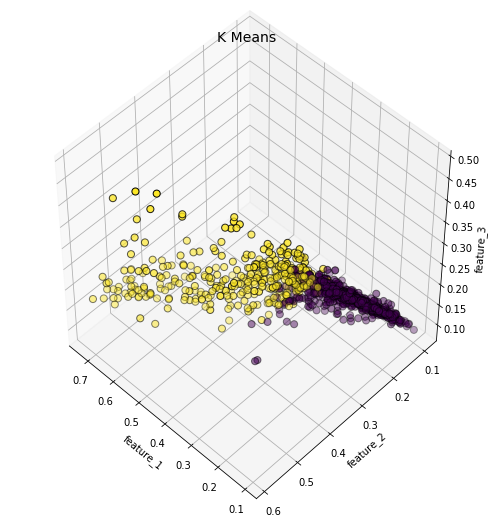

In [15]:
aoi_label = kmeans(org_arr=aoi_arr, in_arr=aoi_arr, n_classes=2)

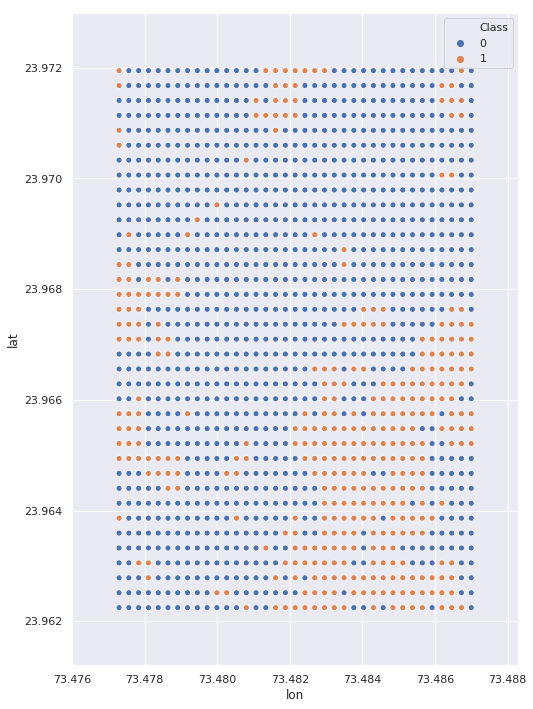

In [16]:
aoi_prediction = pd.Series(aoi_label, name="Class")
aoi_pred_df = aoi_df.merge(aoi_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=aoi_pred_df, x='lon', y='lat', hue='Class')

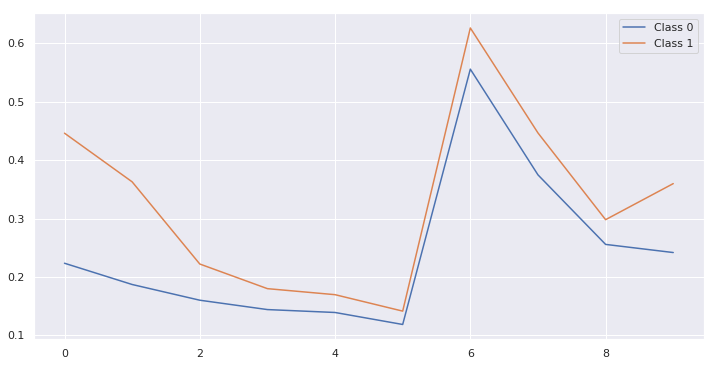

In [17]:
aoi_avg_by_class_df = aoi_pred_df.groupby(['Class']).mean()
aoi_pred_arr = time_series_prep(in_df=aoi_avg_by_class_df, stat_option='NDVI')
fig, ax = plt.subplots(figsize=(12, 6))
for c in aoi_avg_by_class_df.index.values.tolist():
    plt.plot(aoi_pred_arr[c], label='Class ' + str(c))
plt.legend()

Compare Class 0 and Class 1
Ks_2sampResult(statistic=0.48584493085771857, pvalue=1.3322676295501878e-15)
MannwhitneyuResult(statistic=75097.0, pvalue=5.46636723150164e-61)
KruskalResult(statistic=270.07679968210687, pvalue=1.0918704323129177e-60)
Ttest_indResult(statistic=-16.068498906664516, pvalue=1.755693266774015e-46)


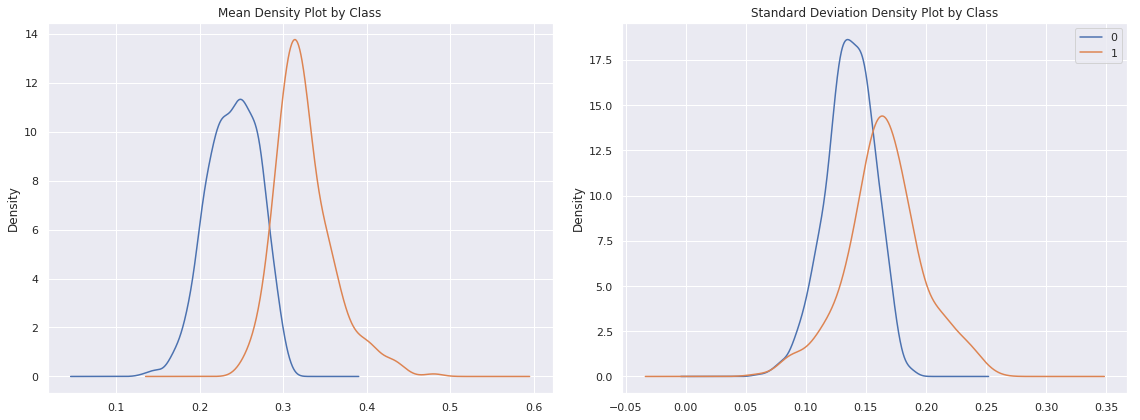

In [18]:
aoi_pred_df['std'] = pd.DataFrame(aoi_arr).std(axis=1)
aoi_pred_df['mean'] = pd.DataFrame(aoi_arr).mean(axis=1)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
df_dict = dict()
for label, df in aoi_pred_df.groupby('Class'):
    df['mean'].plot(kind="kde", ax=axes[0], label=label)
    df['std'].plot(kind="kde", ax=axes[1], label=label)
    df_dict[label] = df['std'].to_numpy()
axes[0].set_title('Mean Density Plot by Class')
axes[1].set_title('Standard Deviation Density Plot by Class')
plt.legend()
fig.tight_layout()

comb = combinations(df_dict.keys(), 2) 
for x, y in list(comb): 
    print('Compare Class {} and Class {}'.format(x, y))
    print(ks_2samp(df_dict[x], df_dict[y]))
    print(mannwhitneyu(df_dict[x], df_dict[y]))
    print(kruskal(df_dict[x], df_dict[y]))
    print(ttest_ind(df_dict[x], df_dict[y], equal_var=False))

Silhouette Coefficient is:  0.31878139619330265
Calinski-Harabasz Index is:  941.4524243660999
Davies-Bouldin Index is:  1.0824996777216296


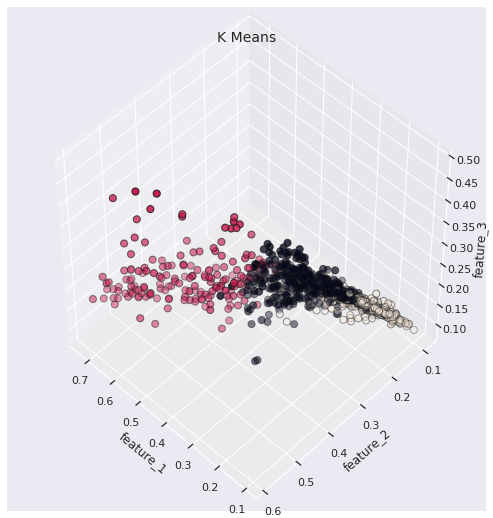

In [19]:
aoi_label = kmeans(org_arr=aoi_arr, in_arr=aoi_arr, n_classes=3)

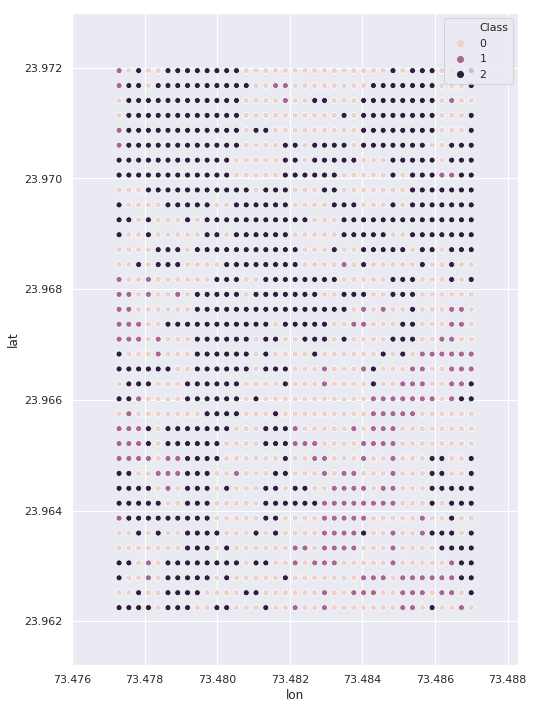

In [20]:
aoi_prediction = pd.Series(aoi_label, name="Class")
aoi_pred_df = aoi_df.merge(aoi_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=aoi_pred_df, x='lon', y='lat', hue='Class')

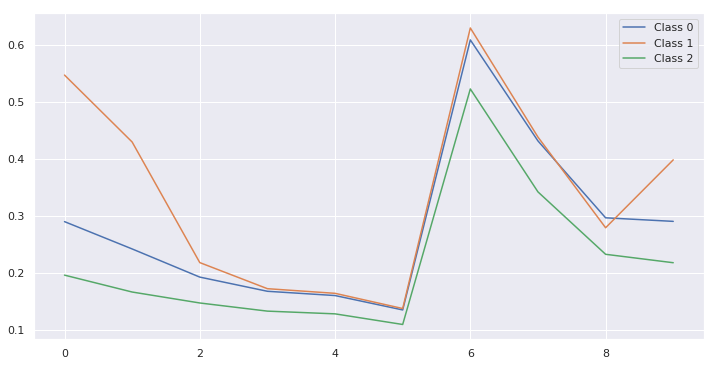

In [21]:
aoi_avg_by_class_df = aoi_pred_df.groupby(['Class']).mean()
aoi_pred_arr = time_series_prep(in_df=aoi_avg_by_class_df, stat_option='NDVI')
fig, ax = plt.subplots(figsize=(12, 6))
for c in aoi_avg_by_class_df.index.values.tolist():
    plt.plot(aoi_pred_arr[c], label='Class ' + str(c))
plt.legend()

Compare Class 0 and Class 1
Ks_2sampResult(statistic=0.559135887136279, pvalue=1.1102230246251565e-16)
MannwhitneyuResult(statistic=17973.0, pvalue=9.131339814972295e-39)
KruskalResult(statistic=168.20853012792213, pvalue=1.8216009476226415e-38)
Ttest_indResult(statistic=-12.83736268617446, pvalue=3.1923778297187628e-28)
Compare Class 0 and Class 2
Ks_2sampResult(statistic=0.45479107232757177, pvalue=1.6653345369377348e-15)
MannwhitneyuResult(statistic=73472.0, pvalue=7.007926226148935e-70)
KruskalResult(statistic=310.8871020758247, pvalue=1.3995111178255765e-69)
Ttest_indResult(statistic=18.973251480173015, pvalue=2.34545963670243e-70)
Compare Class 1 and Class 2
Ks_2sampResult(statistic=0.7763024857399035, pvalue=7.158741623686864e-71)
MannwhitneyuResult(statistic=7876.0, pvalue=1.3960781854026378e-65)
KruskalResult(statistic=291.15673691424263, pvalue=2.7830147794434692e-65)
Ttest_indResult(statistic=21.10744151290697, pvalue=1.3169451125111754e-53)


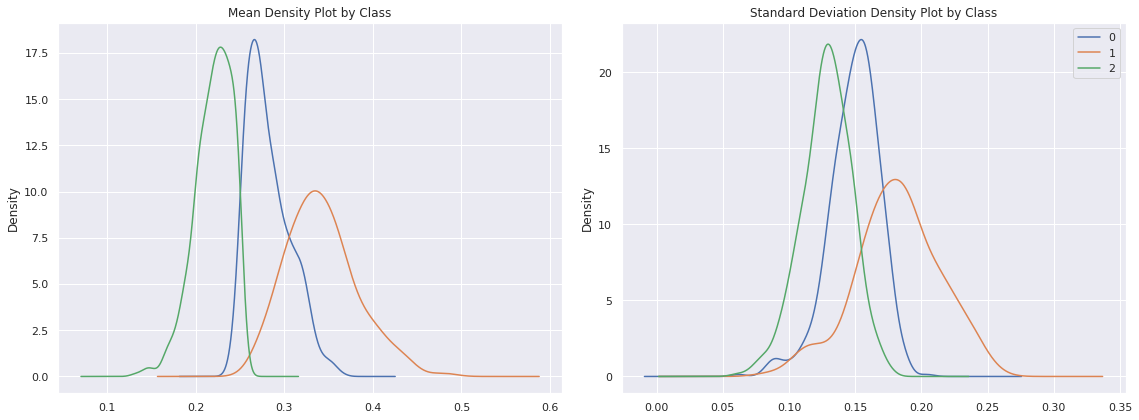

In [22]:
aoi_pred_df['std'] = pd.DataFrame(aoi_arr).std(axis=1)
aoi_pred_df['mean'] = pd.DataFrame(aoi_arr).mean(axis=1)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
df_dict = dict()
for label, df in aoi_pred_df.groupby('Class'):
    df['mean'].plot(kind="kde", ax=axes[0], label=label)
    df['std'].plot(kind="kde", ax=axes[1], label=label)
    df_dict[label] = df['std'].to_numpy()
axes[0].set_title('Mean Density Plot by Class')
axes[1].set_title('Standard Deviation Density Plot by Class')
plt.legend()
fig.tight_layout()

comb = combinations(df_dict.keys(), 2) 
for x, y in list(comb): 
    print('Compare Class {} and Class {}'.format(x, y))
    print(ks_2samp(df_dict[x], df_dict[y]))
    print(mannwhitneyu(df_dict[x], df_dict[y]))
    print(kruskal(df_dict[x], df_dict[y]))
    print(ttest_ind(df_dict[x], df_dict[y], equal_var=False))

Model 2: Agglomerative Clustering

Silhouette Coefficient is:  0.39189223811165785
Calinski-Harabasz Index is:  823.169247525079
Davies-Bouldin Index is:  1.1804185399629488


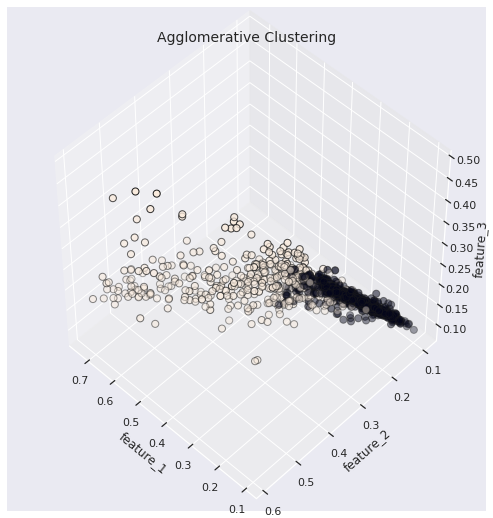

In [23]:
aoi_label = agglomerative(org_arr=aoi_arr, in_arr=aoi_arr, n_classes=2)

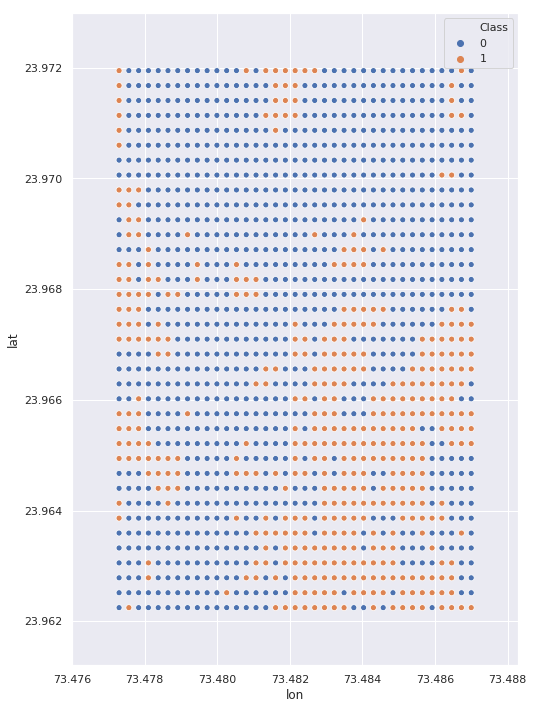

In [24]:
aoi_prediction = pd.Series(aoi_label, name="Class")
aoi_pred_df = aoi_df.merge(aoi_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=aoi_pred_df, x='lon', y='lat', hue='Class')

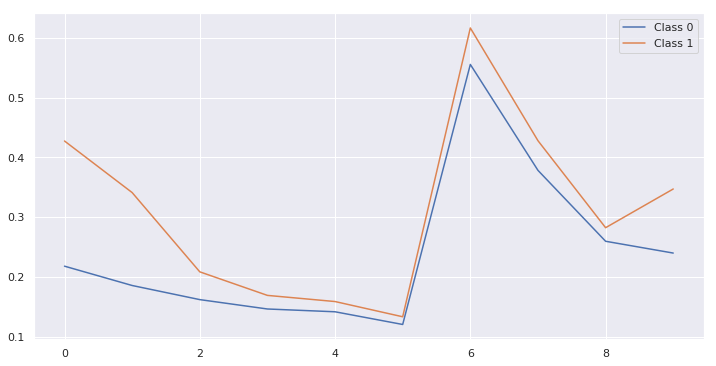

In [25]:
aoi_avg_by_class_df = aoi_pred_df.groupby(['Class']).mean()
aoi_pred_arr = time_series_prep(in_df=aoi_avg_by_class_df, stat_option='NDVI')
fig, ax = plt.subplots(figsize=(12, 6))
for c in aoi_avg_by_class_df.index.values.tolist():
    plt.plot(aoi_pred_arr[c], label='Class ' + str(c))
plt.legend()

Compare Class 0 and Class 1
Ks_2sampResult(statistic=0.48662012798138454, pvalue=7.941448407411133e-60)
MannwhitneyuResult(statistic=83064.0, pvalue=1.461180140848246e-65)
KruskalResult(statistic=291.06189488585824, pvalue=2.9186395627776707e-65)
Ttest_indResult(statistic=-16.87572610393758, pvalue=3.392930605823256e-52)


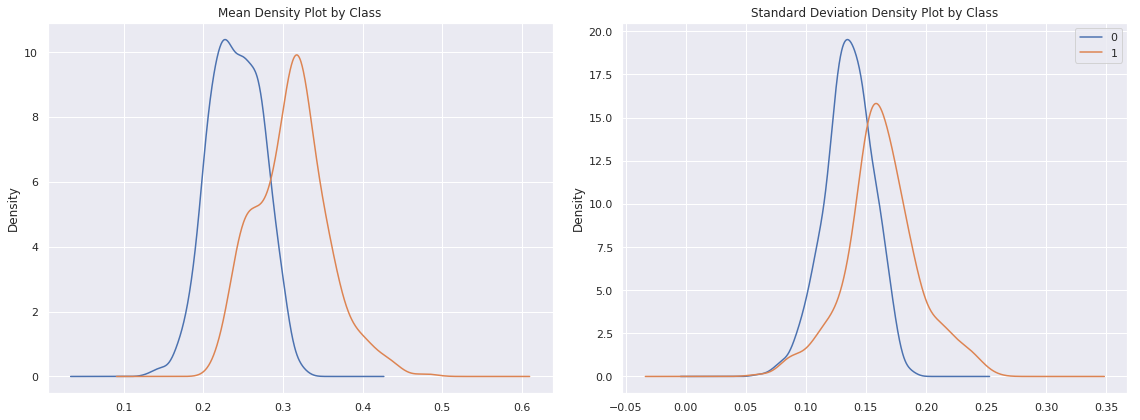

In [26]:
aoi_pred_df['std'] = pd.DataFrame(aoi_arr).std(axis=1)
aoi_pred_df['mean'] = pd.DataFrame(aoi_arr).mean(axis=1)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
df_dict = dict()
for label, df in aoi_pred_df.groupby('Class'):
    df['mean'].plot(kind="kde", ax=axes[0], label=label)
    df['std'].plot(kind="kde", ax=axes[1], label=label)
    df_dict[label] = df['std'].to_numpy()
axes[0].set_title('Mean Density Plot by Class')
axes[1].set_title('Standard Deviation Density Plot by Class')
plt.legend()
fig.tight_layout()

comb = combinations(df_dict.keys(), 2) 
for x, y in list(comb): 
    print('Compare Class {} and Class {}'.format(x, y))
    print(ks_2samp(df_dict[x], df_dict[y]))
    print(mannwhitneyu(df_dict[x], df_dict[y]))
    print(kruskal(df_dict[x], df_dict[y]))
    print(ttest_ind(df_dict[x], df_dict[y], equal_var=False))

Silhouette Coefficient is:  0.21934355687258833
Calinski-Harabasz Index is:  625.4451165079204
Davies-Bouldin Index is:  1.2025635991956853


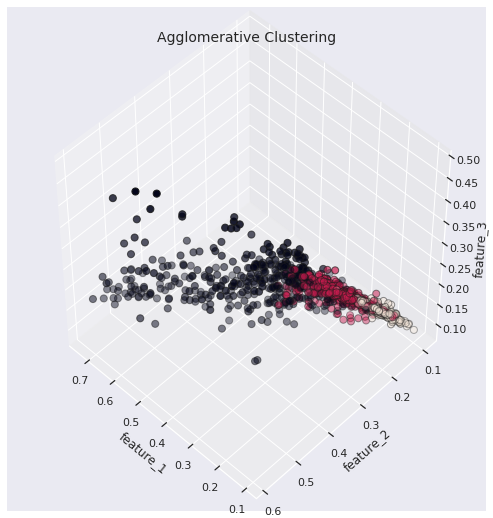

In [27]:
aoi_label = agglomerative(org_arr=aoi_arr, in_arr=aoi_arr, n_classes=3)

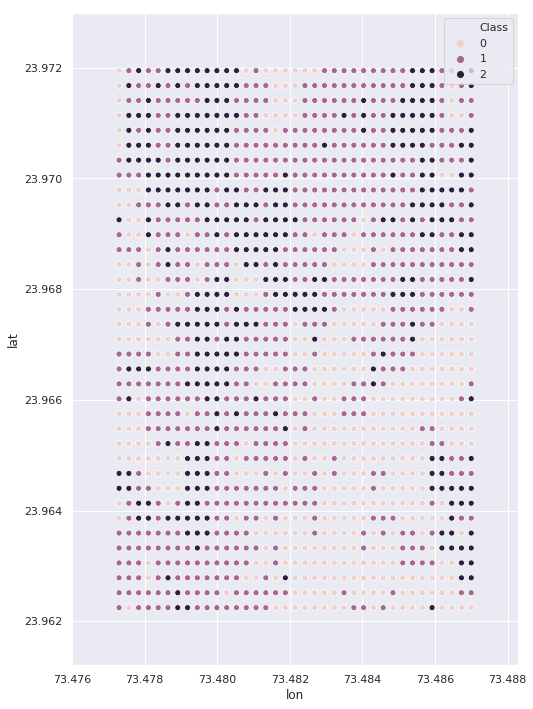

In [28]:
aoi_prediction = pd.Series(aoi_label, name="Class")
aoi_pred_df = aoi_df.merge(aoi_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=aoi_pred_df, x='lon', y='lat', hue='Class')

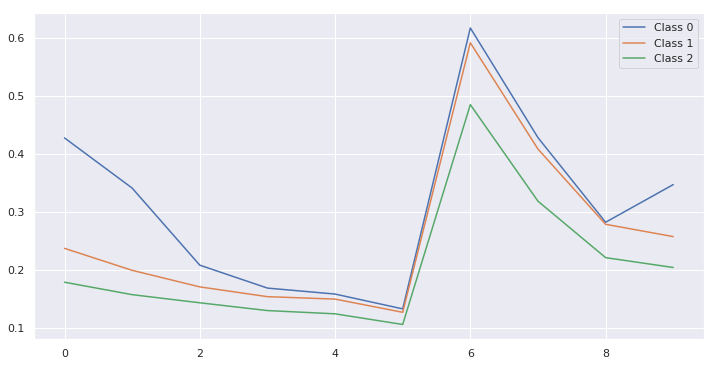

In [29]:
aoi_avg_by_class_df = aoi_pred_df.groupby(['Class']).mean()
aoi_pred_arr = time_series_prep(in_df=aoi_avg_by_class_df, stat_option='NDVI')
fig, ax = plt.subplots(figsize=(12, 6))
for c in aoi_avg_by_class_df.index.values.tolist():
    plt.plot(aoi_pred_arr[c], label='Class ' + str(c))
plt.legend()

Compare Class 0 and Class 1
Ks_2sampResult(statistic=0.3769711056421475, pvalue=2.230109685017942e-31)
MannwhitneyuResult(statistic=72149.0, pvalue=1.4674006569710194e-35)
KruskalResult(statistic=153.53196134849395, pvalue=2.930993208430502e-35)
Ttest_indResult(statistic=11.358900568794562, pvalue=5.5700000109267594e-27)
Compare Class 0 and Class 2
Ks_2sampResult(statistic=0.7850771583905017, pvalue=7.010393766153621e-97)
MannwhitneyuResult(statistic=10915.0, pvalue=4.453673907413236e-84)
KruskalResult(statistic=376.0807141636019, pvalue=8.87693135128665e-84)
Ttest_indResult(statistic=26.419122829266172, pvalue=4.702965815761276e-105)
Compare Class 1 and Class 2
Ks_2sampResult(statistic=0.6622749945781826, pvalue=2.323815880202639e-81)
MannwhitneyuResult(statistic=18778.0, pvalue=3.0458987277970637e-94)
KruskalResult(statistic=422.7741137648659, pvalue=6.07620297565034e-94)
Ttest_indResult(statistic=25.9193751004594, pvalue=3.311174235220173e-100)


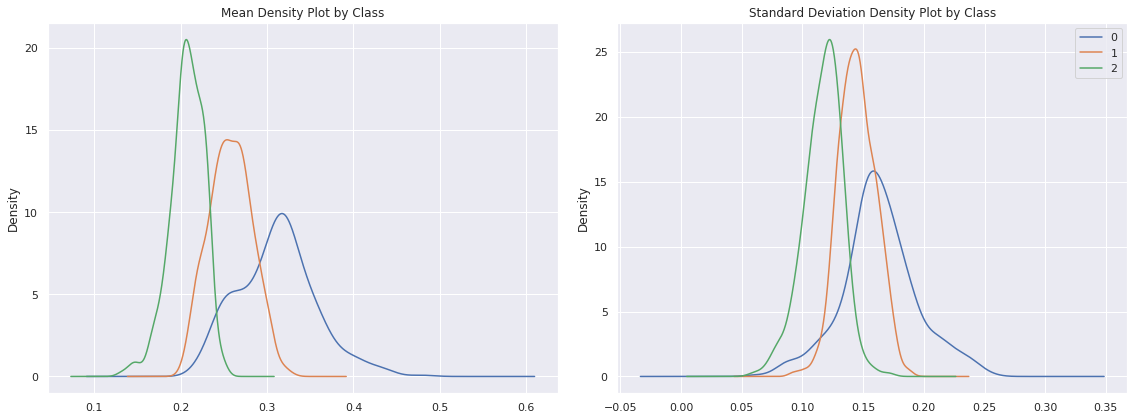

In [30]:
aoi_pred_df['std'] = pd.DataFrame(aoi_arr).std(axis=1)
aoi_pred_df['mean'] = pd.DataFrame(aoi_arr).mean(axis=1)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
df_dict = dict()
for label, df in aoi_pred_df.groupby('Class'):
    df['mean'].plot(kind="kde", ax=axes[0], label=label)
    df['std'].plot(kind="kde", ax=axes[1], label=label)
    df_dict[label] = df['std'].to_numpy()
axes[0].set_title('Mean Density Plot by Class')
axes[1].set_title('Standard Deviation Density Plot by Class')
plt.legend()
fig.tight_layout()

comb = combinations(df_dict.keys(), 2) 
for x, y in list(comb): 
    print('Compare Class {} and Class {}'.format(x, y))
    print(ks_2samp(df_dict[x], df_dict[y]))
    print(mannwhitneyu(df_dict[x], df_dict[y]))
    print(kruskal(df_dict[x], df_dict[y]))
    print(ttest_ind(df_dict[x], df_dict[y], equal_var=False))

Model ?: HDBSCAN

In [31]:
try:
    aoi_label = hdbsc(org_arr=aoi_arr, in_arr=aoi_arr, min_cluster_size=round(aoi_arr.shape[0]*(0.01)))
    skip = 0
except:
    skip = 1
    print("HDBSCAN cannot find more than 1 cluster")

HDBSCAN cannot find more than 1 cluster


In [32]:
if skip == 0:
    aoi_prediction = pd.Series(aoi_label, name="Class")
    aoi_pred_df = aoi_df.merge(aoi_prediction.to_frame(), left_index=True, right_index=True)
    sns.set(rc={'figure.figsize':(8,12)})
    sns.scatterplot(data=aoi_pred_df, x='lon', y='lat', hue='Class')
else:
    print('Skip')

Skip


In [33]:
if skip == 0:
    aoi_pred_df['std'] = pd.DataFrame(aoi_arr).std(axis=1)
    aoi_pred_df['mean'] = pd.DataFrame(aoi_arr).mean(axis=1)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    df_dict = dict()
    for label, df in aoi_pred_df.groupby('Class'):
        df['mean'].plot(kind="kde", ax=axes[0], label=label)
        df['std'].plot(kind="kde", ax=axes[1], label=label)
        df_dict[label] = df['std'].to_numpy()
    axes[0].set_title('Mean Density Plot by Class')
    axes[1].set_title('Standard Deviation Density Plot by Class')
    plt.legend()
    fig.tight_layout()

    comb = combinations(df_dict.keys(), 2) 
    for x, y in list(comb): 
        print('Compare Class {} and Class {}'.format(x, y))
        print(ks_2samp(df_dict[x], df_dict[y]))
        print(mannwhitneyu(df_dict[x], df_dict[y]))
        print(kruskal(df_dict[x], df_dict[y]))
        print(ttest_ind(df_dict[x], df_dict[y], equal_var=False))
else:
    print('Skip')

Skip


Model 3: LSTM Autoencoder + K-Means

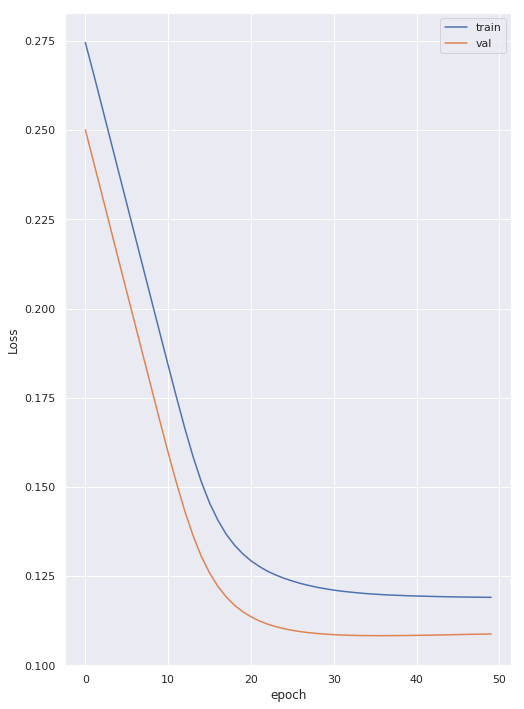

Column 0 has 100.00% of zeros
Column 1 has 100.00% of zeros
Column 2 has 100.00% of zeros
At least 1 column is all zeros. Refit -------------------------------------------


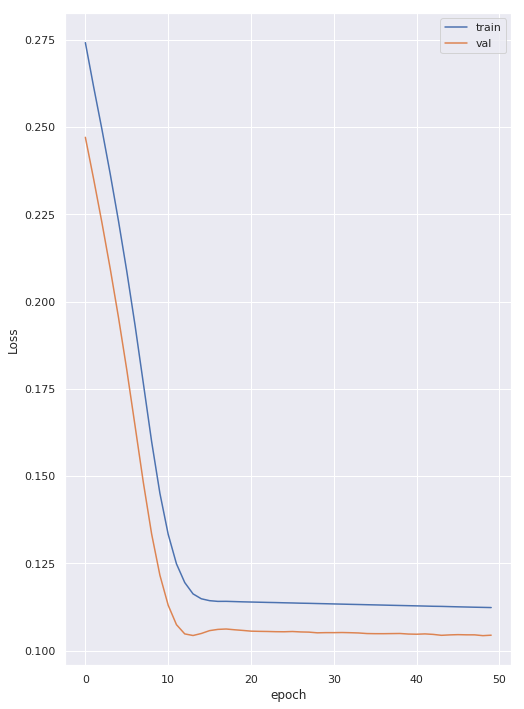

Column 0 has 100.00% of zeros
Column 1 has 100.00% of zeros
Column 2 has 100.00% of zeros
At least 1 column is all zeros. Refit -------------------------------------------


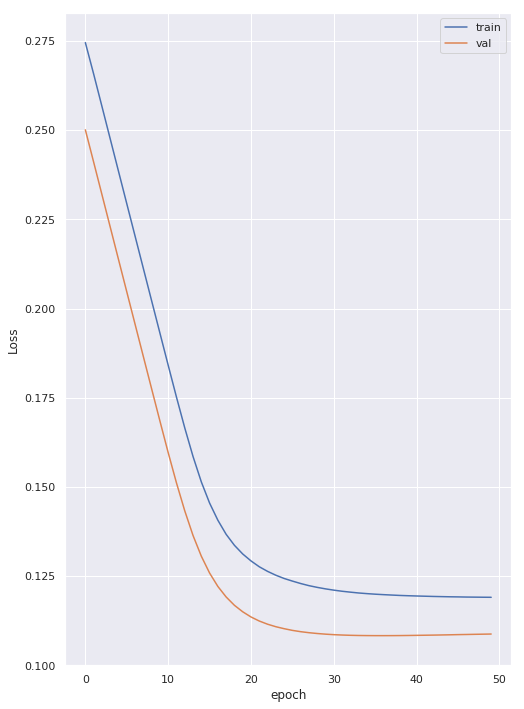

Column 0 has 100.00% of zeros
Column 1 has 100.00% of zeros
Column 2 has 100.00% of zeros
At least 1 column is all zeros. Refit -------------------------------------------


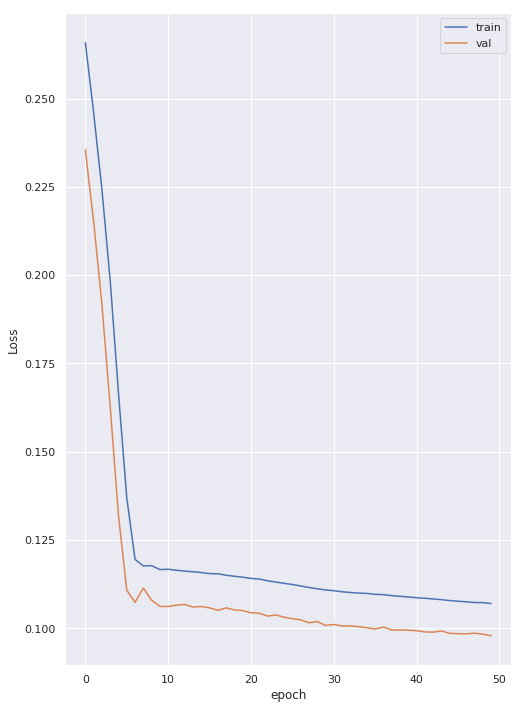

Column 0 has 100.00% of zeros
Column 1 has 0.44% of zeros
Column 2 has 100.00% of zeros
At least 1 column is all zeros. Refit -------------------------------------------


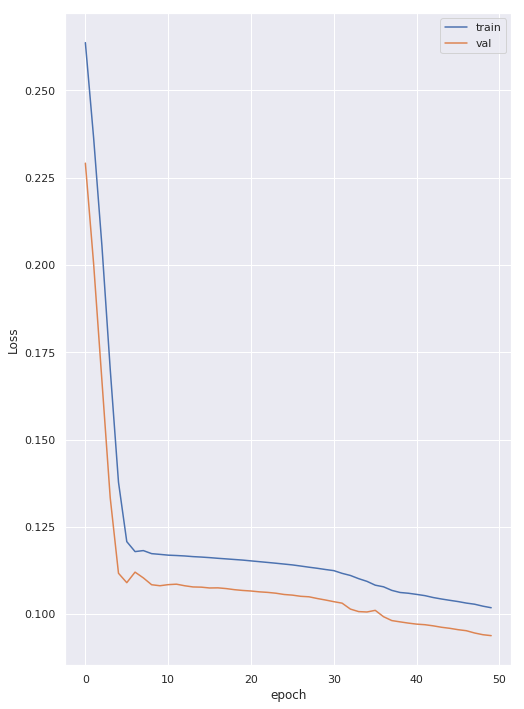

Column 0 has 0.00% of zeros
Column 1 has 0.00% of zeros
Column 2 has 0.15% of zeros


In [34]:
aoi_feature,aoi_repeat = LSTM_autoencoder_plus(in_arr=aoi_arr, n_features=3, n_epochs=50)

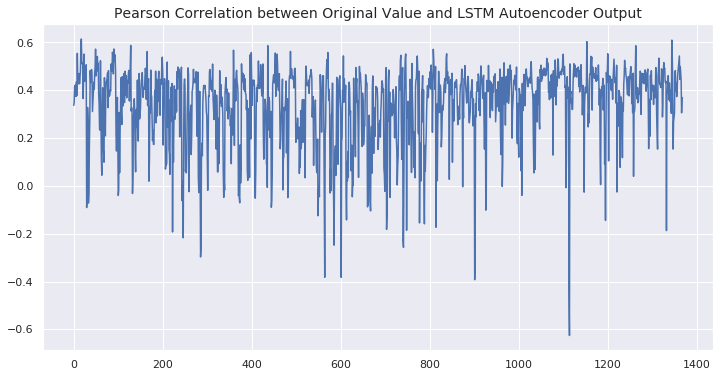

In [35]:
aoi_repeat_2 = aoi_repeat.reshape(aoi_repeat.shape[0], aoi_repeat.shape[1])
pear_coef = [pearsonr(aoi_arr[i, :], aoi_repeat_2[i, :])[0] for i in range(aoi_arr.shape[0])]
fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Pearson Correlation between Original Value and LSTM Autoencoder Output", fontsize=14)
plt.plot(pear_coef)

Silhouette Coefficient is:  0.31766134540979973
Calinski-Harabasz Index is:  700.5282580906393
Davies-Bouldin Index is:  1.2338602378871295


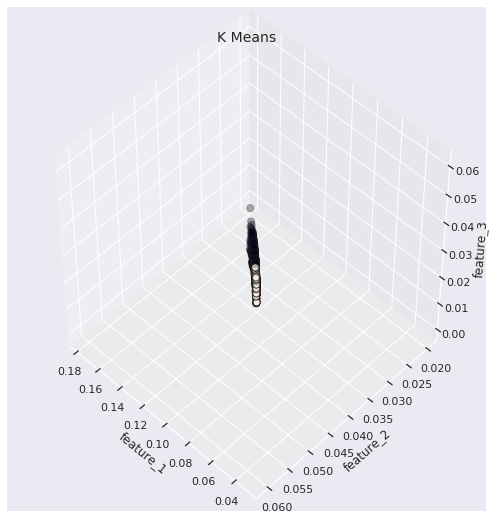

In [36]:
aoi_label = kmeans(org_arr=aoi_arr, in_arr=aoi_feature, n_classes=2)

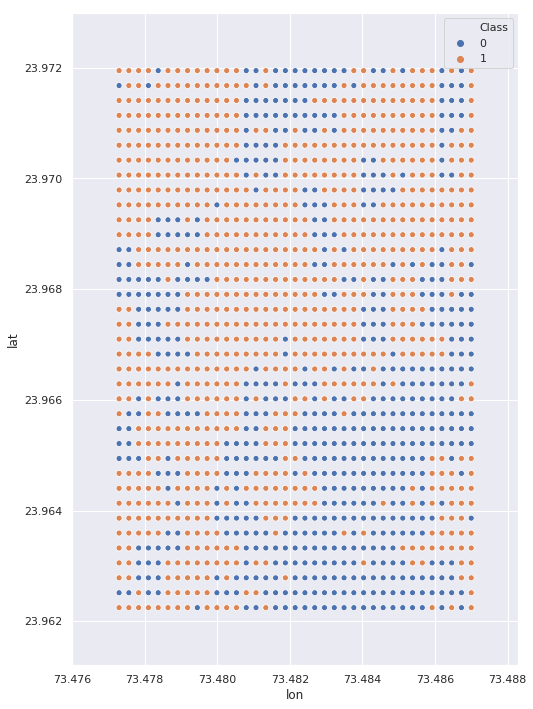

In [37]:
aoi_prediction = pd.Series(aoi_label, name="Class")
aoi_pred_df = aoi_df.merge(aoi_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=aoi_pred_df, x='lon', y='lat', hue='Class')

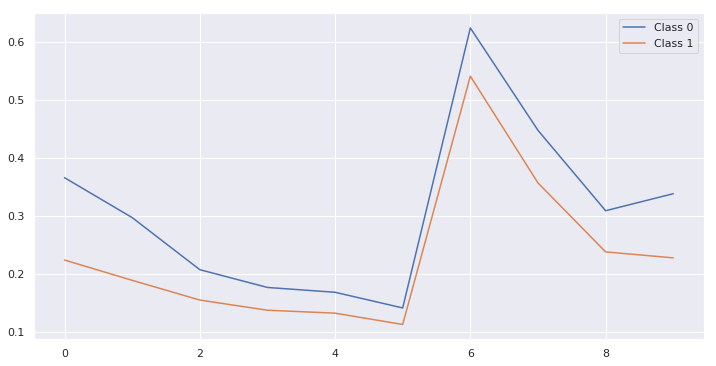

In [38]:
aoi_avg_by_class_df = aoi_pred_df.groupby(['Class']).mean()
aoi_pred_arr = time_series_prep(in_df=aoi_avg_by_class_df, stat_option='NDVI')
fig, ax = plt.subplots(figsize=(12, 6))
for c in aoi_avg_by_class_df.index.values.tolist():
    plt.plot(aoi_pred_arr[c], label='Class ' + str(c))
plt.legend()

Compare Class 0 and Class 1
Ks_2sampResult(statistic=0.44140849681878114, pvalue=2.1094237467877974e-15)
MannwhitneyuResult(statistic=98882.0, pvalue=2.209328721651198e-70)
KruskalResult(statistic=313.1879904345433, pvalue=4.4132009049598014e-70)
Ttest_indResult(statistic=18.02619341360159, pvalue=4.7882510333363705e-63)


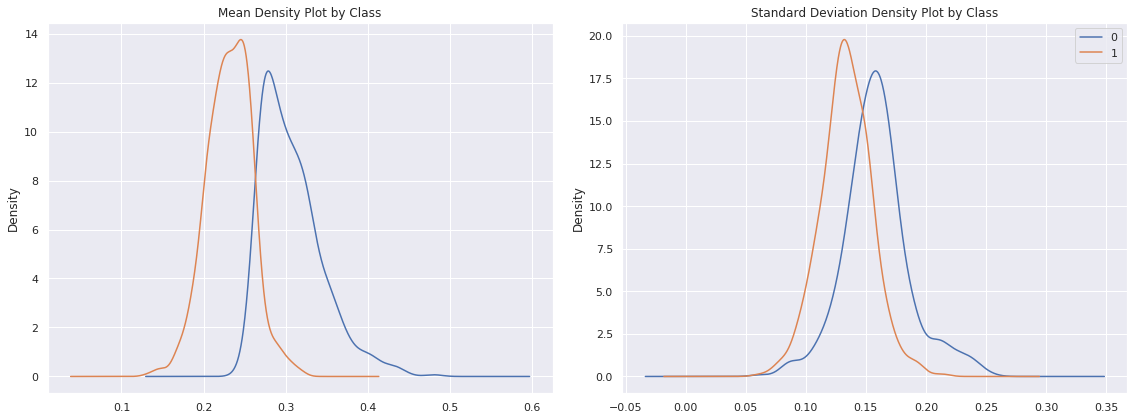

In [39]:
aoi_pred_df['std'] = pd.DataFrame(aoi_arr).std(axis=1)
aoi_pred_df['mean'] = pd.DataFrame(aoi_arr).mean(axis=1)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
df_dict = dict()
for label, df in aoi_pred_df.groupby('Class'):
    df['mean'].plot(kind="kde", ax=axes[0], label=label)
    df['std'].plot(kind="kde", ax=axes[1], label=label)
    df_dict[label] = df['std'].to_numpy()
axes[0].set_title('Mean Density Plot by Class')
axes[1].set_title('Standard Deviation Density Plot by Class')
plt.legend()
fig.tight_layout()

comb = combinations(df_dict.keys(), 2) 
for x, y in list(comb): 
    print('Compare Class {} and Class {}'.format(x, y))
    print(ks_2samp(df_dict[x], df_dict[y]))
    print(mannwhitneyu(df_dict[x], df_dict[y]))
    print(kruskal(df_dict[x], df_dict[y]))
    print(ttest_ind(df_dict[x], df_dict[y], equal_var=False))

Silhouette Coefficient is:  0.2230040687175616
Calinski-Harabasz Index is:  577.3113719864934
Davies-Bouldin Index is:  1.385750568676655


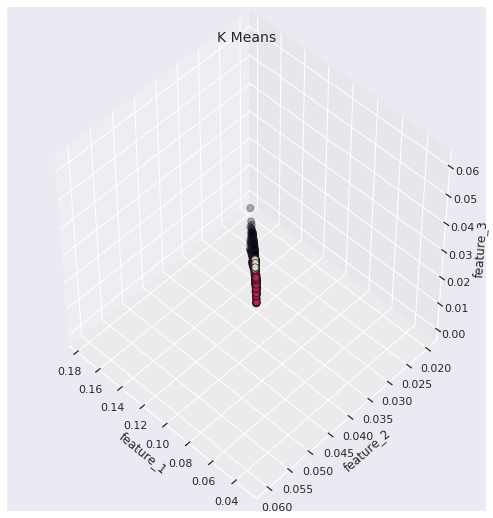

In [40]:
aoi_label = kmeans(org_arr=aoi_arr, in_arr=aoi_feature, n_classes=3)

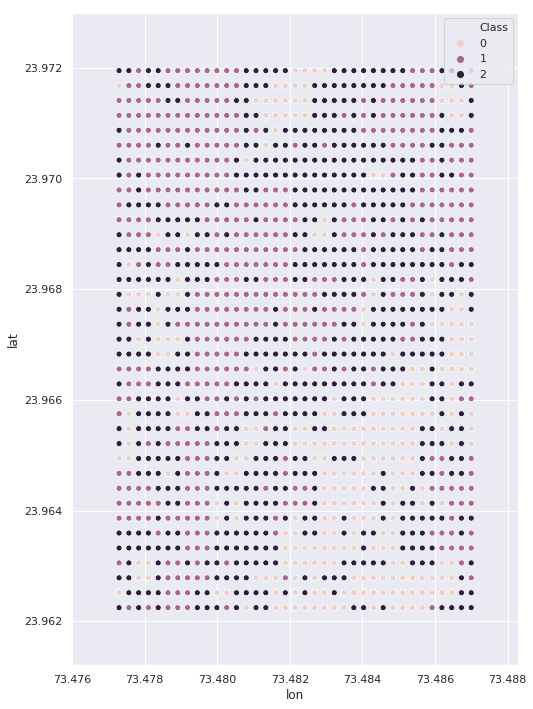

In [41]:
aoi_prediction = pd.Series(aoi_label, name="Class")
aoi_pred_df = aoi_df.merge(aoi_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=aoi_pred_df, x='lon', y='lat', hue='Class')

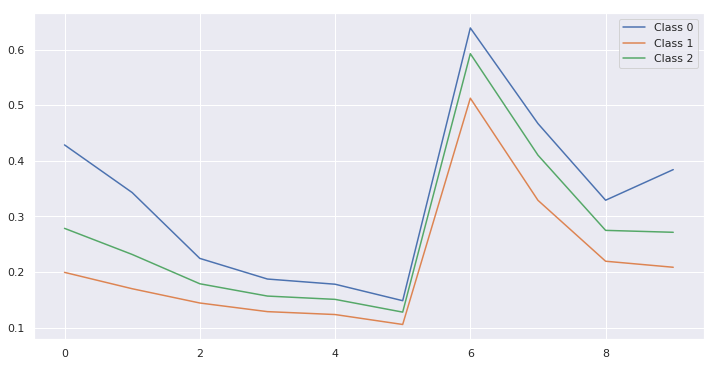

In [42]:
aoi_avg_by_class_df = aoi_pred_df.groupby(['Class']).mean()
aoi_pred_arr = time_series_prep(in_df=aoi_avg_by_class_df, stat_option='NDVI')
fig, ax = plt.subplots(figsize=(12, 6))
for c in aoi_avg_by_class_df.index.values.tolist():
    plt.plot(aoi_pred_arr[c], label='Class ' + str(c))
plt.legend()

Compare Class 0 and Class 1
Ks_2sampResult(statistic=0.6536722992446076, pvalue=2.0609668781891034e-65)
MannwhitneyuResult(statistic=16751.0, pvalue=9.684549033895347e-66)
KruskalResult(statistic=291.8850930522458, pvalue=1.9311504546145353e-65)
Ttest_indResult(statistic=19.319845140861425, pvalue=5.463488001905819e-60)
Compare Class 0 and Class 2
Ks_2sampResult(statistic=0.36267523090627785, pvalue=1.1102230246251565e-16)
MannwhitneyuResult(statistic=48843.0, pvalue=7.308742232018871e-25)
KruskalResult(statistic=104.64686427496827, pvalue=1.45963332457121e-24)
Ttest_indResult(statistic=9.223277305600451, pvalue=1.91072275847681e-18)
Compare Class 1 and Class 2
Ks_2sampResult(statistic=0.4830022918258212, pvalue=7.783169142980955e-55)
MannwhitneyuResult(statistic=61299.0, pvalue=1.622494829942287e-61)
KruskalResult(statistic=272.4978760072604, pvalue=3.239792313146431e-61)
Ttest_indResult(statistic=-17.281527781109006, pvalue=7.7334365699156235e-59)


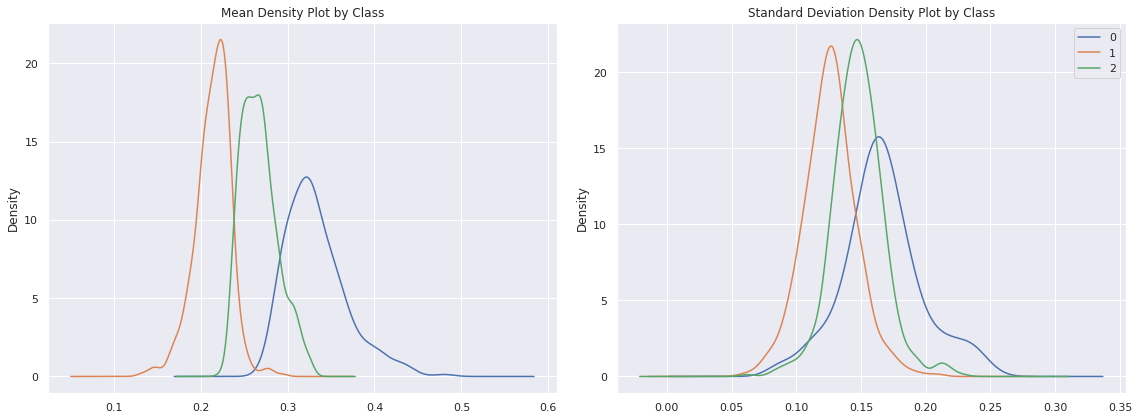

In [43]:
aoi_pred_df['std'] = pd.DataFrame(aoi_arr).std(axis=1)
aoi_pred_df['mean'] = pd.DataFrame(aoi_arr).mean(axis=1)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
df_dict = dict()
for label, df in aoi_pred_df.groupby('Class'):
    df['mean'].plot(kind="kde", ax=axes[0], label=label)
    df['std'].plot(kind="kde", ax=axes[1], label=label)
    df_dict[label] = df['std'].to_numpy()
axes[0].set_title('Mean Density Plot by Class')
axes[1].set_title('Standard Deviation Density Plot by Class')
plt.legend()
fig.tight_layout()

comb = combinations(df_dict.keys(), 2) 
for x, y in list(comb): 
    print('Compare Class {} and Class {}'.format(x, y))
    print(ks_2samp(df_dict[x], df_dict[y]))
    print(mannwhitneyu(df_dict[x], df_dict[y]))
    print(kruskal(df_dict[x], df_dict[y]))
    print(ttest_ind(df_dict[x], df_dict[y], equal_var=False))

Model 4: LSTM Autoencoder + Agglomerative Clustering

Silhouette Coefficient is:  0.3998049852480205
Calinski-Harabasz Index is:  665.1219383852816
Davies-Bouldin Index is:  1.1445196455113766


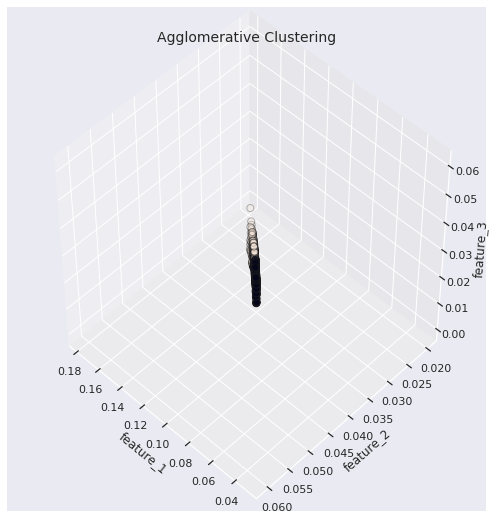

In [44]:
aoi_label = agglomerative(org_arr=aoi_arr, in_arr=aoi_feature, n_classes=2)

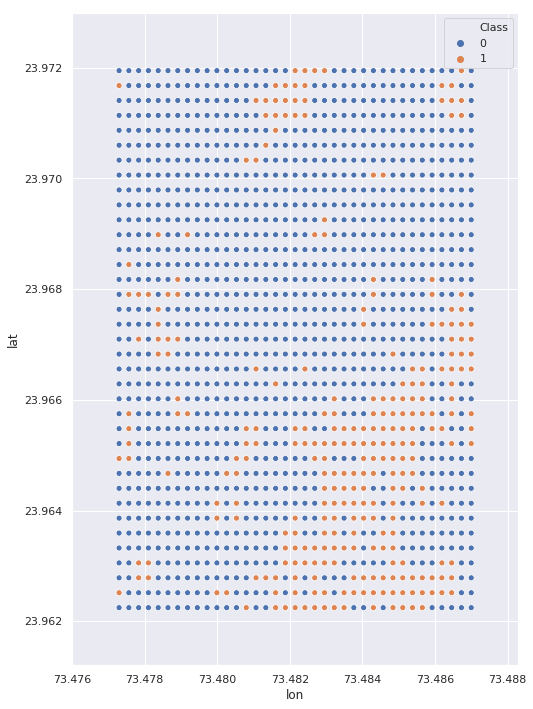

In [45]:
aoi_prediction = pd.Series(aoi_label, name="Class")
aoi_pred_df = aoi_df.merge(aoi_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=aoi_pred_df, x='lon', y='lat', hue='Class')

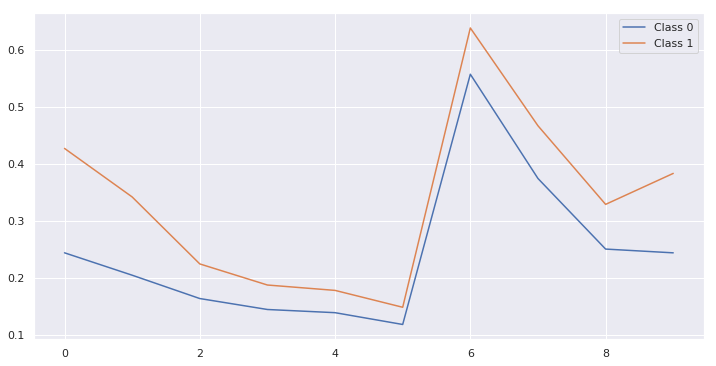

In [46]:
aoi_avg_by_class_df = aoi_pred_df.groupby(['Class']).mean()
aoi_pred_arr = time_series_prep(in_df=aoi_avg_by_class_df, stat_option='NDVI')
fig, ax = plt.subplots(figsize=(12, 6))
for c in aoi_avg_by_class_df.index.values.tolist():
    plt.plot(aoi_pred_arr[c], label='Class ' + str(c))
plt.legend()

Compare Class 0 and Class 1
Ks_2sampResult(statistic=0.47091184111012463, pvalue=3.2594831128879872e-43)
MannwhitneyuResult(statistic=65874.0, pvalue=9.594100072749162e-49)
KruskalResult(statistic=213.92081076118484, pvalue=1.9164290081011e-48)
Ttest_indResult(statistic=-14.222324955822085, pvalue=9.240505729205954e-37)


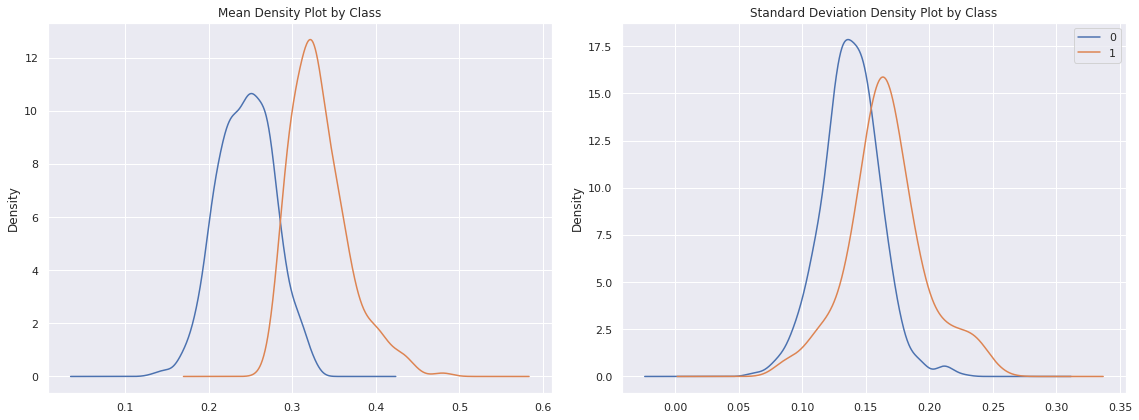

In [47]:
aoi_pred_df['std'] = pd.DataFrame(aoi_arr).std(axis=1)
aoi_pred_df['mean'] = pd.DataFrame(aoi_arr).mean(axis=1)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
df_dict = dict()
for label, df in aoi_pred_df.groupby('Class'):
    df['mean'].plot(kind="kde", ax=axes[0], label=label)
    df['std'].plot(kind="kde", ax=axes[1], label=label)
    df_dict[label] = df['std'].to_numpy()
axes[0].set_title('Mean Density Plot by Class')
axes[1].set_title('Standard Deviation Density Plot by Class')
plt.legend()
fig.tight_layout()

comb = combinations(df_dict.keys(), 2) 
for x, y in list(comb): 
    print('Compare Class {} and Class {}'.format(x, y))
    print(ks_2samp(df_dict[x], df_dict[y]))
    print(mannwhitneyu(df_dict[x], df_dict[y]))
    print(kruskal(df_dict[x], df_dict[y]))
    print(ttest_ind(df_dict[x], df_dict[y], equal_var=False))

Silhouette Coefficient is:  0.22199330162226208
Calinski-Harabasz Index is:  574.6632434459743
Davies-Bouldin Index is:  1.3913895146489146


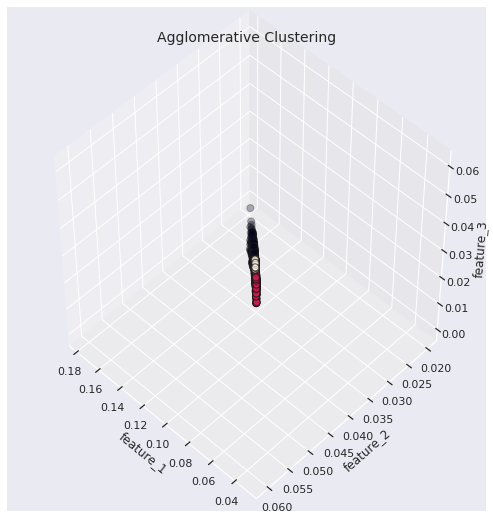

In [48]:
aoi_label = agglomerative(org_arr=aoi_arr, in_arr=aoi_feature, n_classes=3)

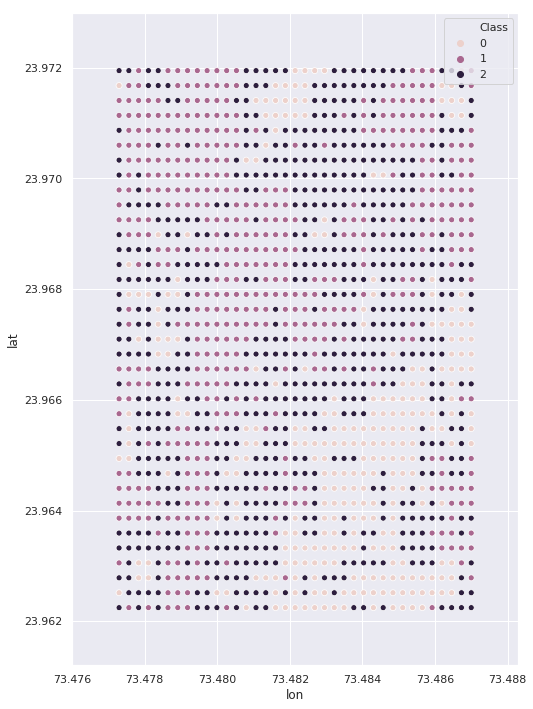

In [49]:
aoi_prediction = pd.Series(aoi_label, name="Class")
aoi_pred_df = aoi_df.merge(aoi_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=aoi_pred_df, x='lon', y='lat', hue='Class')

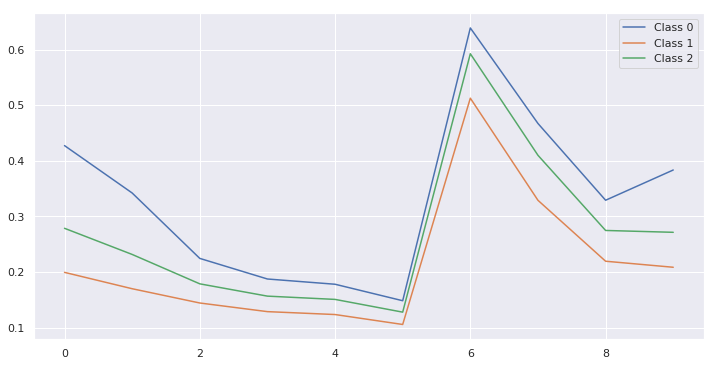

In [50]:
aoi_avg_by_class_df = aoi_pred_df.groupby(['Class']).mean()
aoi_pred_arr = time_series_prep(in_df=aoi_avg_by_class_df, stat_option='NDVI')
fig, ax = plt.subplots(figsize=(12, 6))
for c in aoi_avg_by_class_df.index.values.tolist():
    plt.plot(aoi_pred_arr[c], label='Class ' + str(c))
plt.legend()

Compare Class 0 and Class 1
Ks_2sampResult(statistic=0.6554320652992379, pvalue=4.637386203365329e-66)
MannwhitneyuResult(statistic=16820.0, pvalue=3.6498759778794867e-66)
KruskalResult(statistic=293.83016336761693, pvalue=7.278081476845035e-66)
Ttest_indResult(statistic=19.38479463861956, pvalue=1.8759310901630177e-60)
Compare Class 0 and Class 2
Ks_2sampResult(statistic=0.36210640608034744, pvalue=2.839380545165918e-22)
MannwhitneyuResult(statistic=49054.0, pvalue=6.251188369938884e-25)
KruskalResult(statistic=104.95656079779337, pvalue=1.2484295448605538e-24)
Ttest_indResult(statistic=9.244678359911232, pvalue=1.5483785654230008e-18)
Compare Class 1 and Class 2
Ks_2sampResult(statistic=0.48228314126953714, pvalue=1.3488847981550342e-54)
MannwhitneyuResult(statistic=61230.0, pvalue=2.990277811645798e-61)
KruskalResult(statistic=271.2795231050977, pvalue=5.970973811337478e-61)
Ttest_indResult(statistic=-17.239572719475984, pvalue=1.3457148991538456e-58)


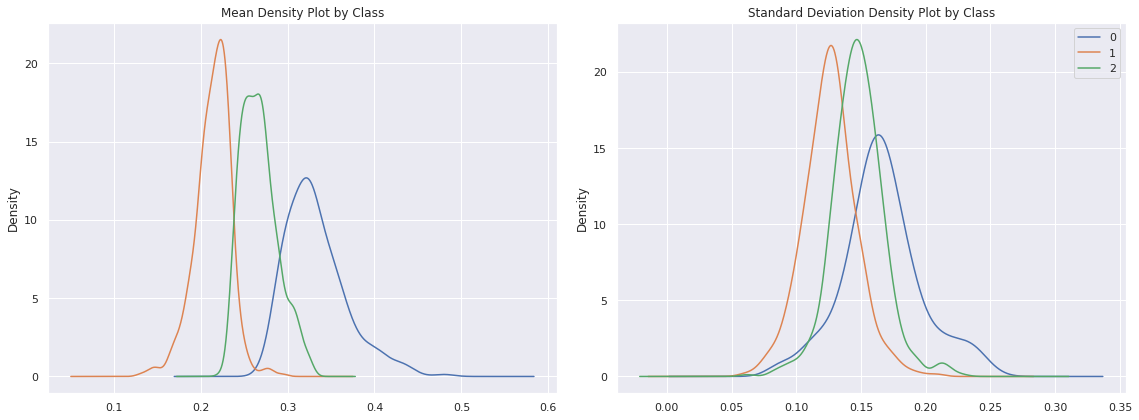

In [51]:
aoi_pred_df['std'] = pd.DataFrame(aoi_arr).std(axis=1)
aoi_pred_df['mean'] = pd.DataFrame(aoi_arr).mean(axis=1)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
df_dict = dict()
for label, df in aoi_pred_df.groupby('Class'):
    df['mean'].plot(kind="kde", ax=axes[0], label=label)
    df['std'].plot(kind="kde", ax=axes[1], label=label)
    df_dict[label] = df['std'].to_numpy()
axes[0].set_title('Mean Density Plot by Class')
axes[1].set_title('Standard Deviation Density Plot by Class')
plt.legend()
fig.tight_layout()

comb = combinations(df_dict.keys(), 2) 
for x, y in list(comb): 
    print('Compare Class {} and Class {}'.format(x, y))
    print(ks_2samp(df_dict[x], df_dict[y]))
    print(mannwhitneyu(df_dict[x], df_dict[y]))
    print(kruskal(df_dict[x], df_dict[y]))
    print(ttest_ind(df_dict[x], df_dict[y], equal_var=False))